<a href="https://colab.research.google.com/github/nancynwei/AxmlParserPY/blob/master/Robinhood_Forecasting_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robinhood Business Operations Analyst Exercise
## [Nancy Wei](https://linkedin.com/in/nancynwei/)  |  Oct. 4, 2019

### Goal:  Long term forecast challenge.
### Use the weekly_data to build a long term weekly forecasting model to project number of weekly tickets in the next 3 months.

## Import Python Libraries

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)

# numpy
import numpy as np
print('numpy: %s' % np.__version__)

# matplotlib and pyplot
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__)

# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)

# scikit-learn
import sklearn
from sklearn.metrics import mean_squared_error
print('sklearn: %s' % sklearn.__version__)

# statsmodels
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.stattools
print('statsmodels: %s' % statsmodels.__version__)

# seaborn
import seaborn as sns

#print plots in this notebook
%matplotlib inline

scipy: 1.3.1
numpy: 1.16.5
matplotlib: 3.0.3
pandas: 0.24.2
sklearn: 0.21.3
statsmodels: 0.10.1


## Import Data
###Mount the Google Drive to Google Colab.

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".

!ls "/content/gdrive/My Drive/Robinhood/Data"

Daily.csv  Weekly.csv


In [4]:
# Set root path to folder containing the data to be used
root_path = "/content/gdrive/My\\ Drive/Robinhood/Data"

# Check that the path is correct - should see the data file using the ls command
!ls $root_path

Daily.csv  Weekly.csv


In [0]:
# Copy the data file to the local folder
!cp $root_path/"Daily.csv" "daily.csv"
!cp $root_path/"Weekly.csv" "weekly.csv"

## Convert data format to dataframe

### week_num_ticket: historical number of issue tickets that customer created per week.
### v1: historical number of transactions per week.
### v2: historical the other variable which might be correlated to week_num_ticket.
### Note: the projected growth rate for number of transactions in the next 3 months is 0.1% per week.

In [6]:
df_weekly = pd.read_csv('weekly.csv')

# convert 'week' column to datetime object and print its datatype
df_weekly.week = pd.to_datetime(df_weekly.week)
print(df_weekly.week.dtypes)
print("number of rows: ", df_weekly.shape[0])
df_weekly.head()

datetime64[ns]
number of rows:  135


,week,week_num_ticket,v1,v2
0,2017-01-02,192860,8132660,343080
1,2017-01-09,207540,8505760,402180
2,2017-01-16,143960,8447080,380020
3,2017-01-23,154580,8577100,331440
4,2017-01-30,185860,9513500,586920


In [7]:
df_weekly.week[0].day
df_weekly['year'] = df_weekly['week'].map(lambda x: x.year)
df_weekly['month'] = df_weekly['week'].map(lambda x: x.month)
df_weekly['day'] = df_weekly['week'].map(lambda x: x.day)

columnTitles = ['week', 'year', 'month', 'day', 'week_num_ticket', 'v1', 'v2']
df_weekly = df_weekly.reindex(columns=columnTitles)

print("number of rows: ", df_weekly.shape[0])
df_weekly.head()

number of rows:  135


,week,year,month,day,week_num_ticket,v1,v2
0,2017-01-02,2017,1,2,192860,8132660,343080
1,2017-01-09,2017,1,9,207540,8505760,402180
2,2017-01-16,2017,1,16,143960,8447080,380020
3,2017-01-23,2017,1,23,154580,8577100,331440
4,2017-01-30,2017,1,30,185860,9513500,586920


## Get some useful statistics from the dataset.

In [8]:
df_weekly.week_num_ticket.describe()

count       135.000000
mean     391067.851852
std      143315.656811
min       98720.000000
25%      289360.000000
50%      418980.000000
75%      477760.000000
max      942740.000000
Name: week_num_ticket, dtype: float64

### Find the weeks in which there were highest number of tickets.

In [9]:
df_weekly_desc = df_weekly.sort_values(by='week_num_ticket', ascending=False)
df_weekly_desc.head()

,week,year,month,day,week_num_ticket,v1,v2
101,2018-12-10,2018,12,10,942740,45402340,1828020
57,2018-02-05,2018,2,5,745360,35301540,2318160
55,2018-01-22,2018,1,22,690800,34656800,4284500
108,2019-01-28,2019,1,28,686640,48857680,2026120
109,2019-02-04,2019,2,4,634600,52141920,2049620


### Find the weeks in which there were lowest number of tickets.

In [10]:
df_weekly_asc = df_weekly.sort_values(by='week_num_ticket', ascending=True)
df_weekly_asc.head()

,week,year,month,day,week_num_ticket,v1,v2
13,2017-04-03,2017,4,3,98720,11138840,506340
21,2017-05-29,2017,5,29,132500,12252400,485680
2,2017-01-16,2017,1,16,143960,8447080,380020
3,2017-01-23,2017,1,23,154580,8577100,331440
26,2017-07-03,2017,7,3,161680,13112860,544860


### Take a quick look at how the data looks over time.  We see that this time series data is **not stationary**.

Some types of Stationary Time Series:

**Stationary Process**: A process that generates a stationary series of observations.

**Stationary Mode**l: A model that describes a stationary series of observations.

**Trend Stationary**: A time series that does not exhibit a trend.

**Seasonal Stationary**: A time series that does not exhibit seasonality.

**Strictly Stationary**: A mathematical definition of a stationary process, specifically that the joint distribution of observations is invariant to time shift.

### Time series data is stationary if they do not have trend or seasonal effects.  

We see from the plot that the data generally increases from 2017-01 to 2018-02, and then takes a sharp decrease from 2018-02 to around 2018-03.  Then the data gradually stays in the same range until a sharp increase in 2019-01, then takes a dive around 2019-02.  There seems to be seasonality effects in this dataset that we should investigate.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


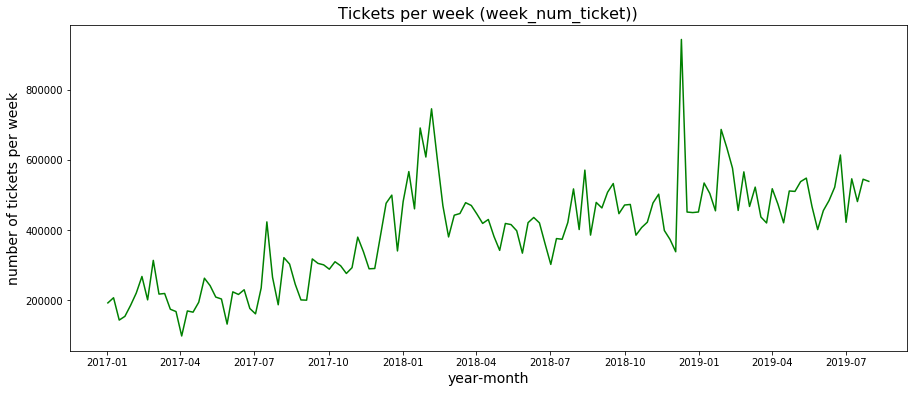

In [11]:
x = df_weekly.week
y = df_weekly.week_num_ticket
plt.figure(figsize=(15, 6))
plt.title('Tickets per week (week_num_ticket))', fontsize=16)
plt.xlabel('year-month', fontsize=14)
plt.ylabel('number of tickets per week', fontsize=14)
plt.plot(x,y, color='green')
plt.show()

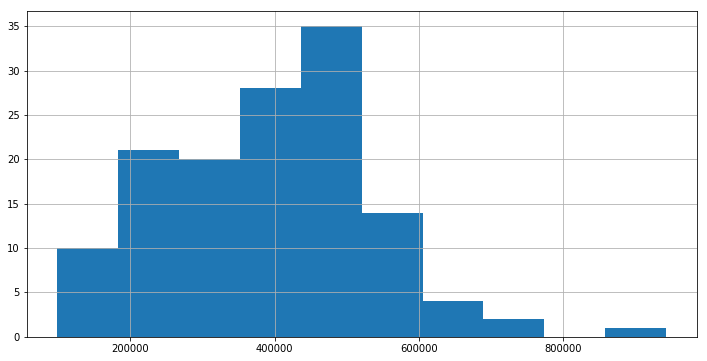

In [12]:
plt.figure(figsize=(12, 6))
y.hist()
plt.show()

### I am given two additional variables: v1 (number of transactions) and v2 (some other variable).
### First, I want to investigate the correlation between:
**number of tickets and v1**



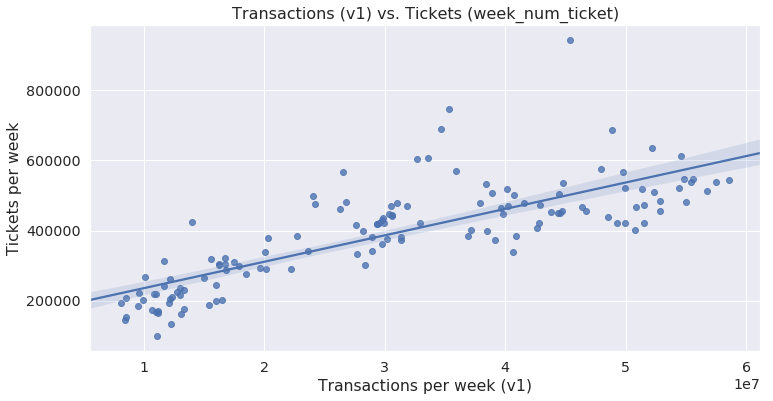

In [13]:
x, y = df_weekly.v1, df_weekly.week_num_ticket

plt.figure(figsize=(12, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(font_scale=1.3)
plt.title('Transactions (v1) vs. Tickets (week_num_ticket)', fontsize=16)

ax = sns.regplot(x, y)
ax.set(xlabel='Transactions per week (v1)', ylabel='Tickets per week')
plt.show()

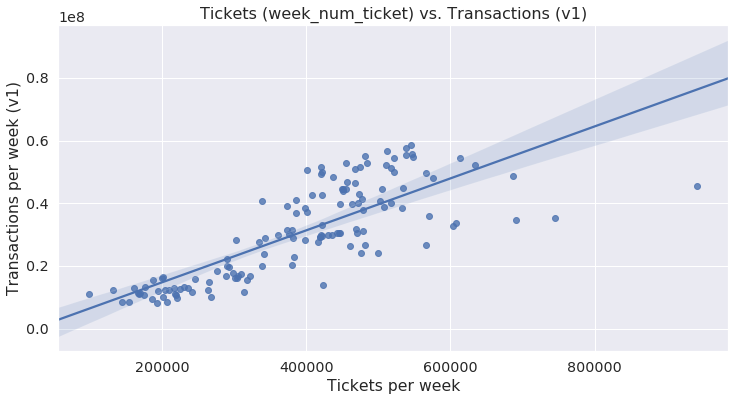

In [14]:
x, y = df_weekly.week_num_ticket, df_weekly.v1

plt.figure(figsize=(12, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(font_scale=1.3)
plt.title('Tickets (week_num_ticket) vs. Transactions (v1)', fontsize=16)

ax = sns.regplot(x, y)
ax.set(xlabel='Tickets per week', ylabel='Transactions per week (v1)')
plt.show()

### The two variables don't seem to be exactly linear.  I am curious to see what each variable's density looks like.
### So I'm trying out a joint plot to see what the shape of each variable's distribution looks like.

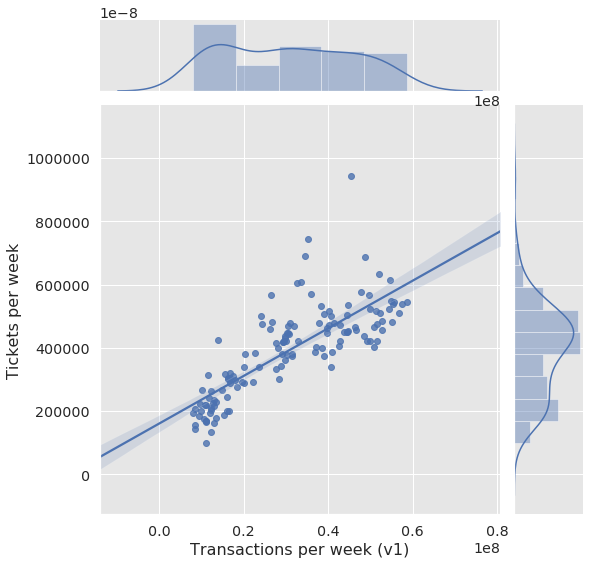

In [15]:
x, y = df_weekly.v1, df_weekly.week_num_ticket

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
h = sns.jointplot(x,y, data=y, height=8, kind="reg")
h.set_axis_labels('Transactions per week (v1)', 'Tickets per week', fontsize=16)
plt.show()

### Next, I want to investigate the correlation between:
**number of tickets and v2**

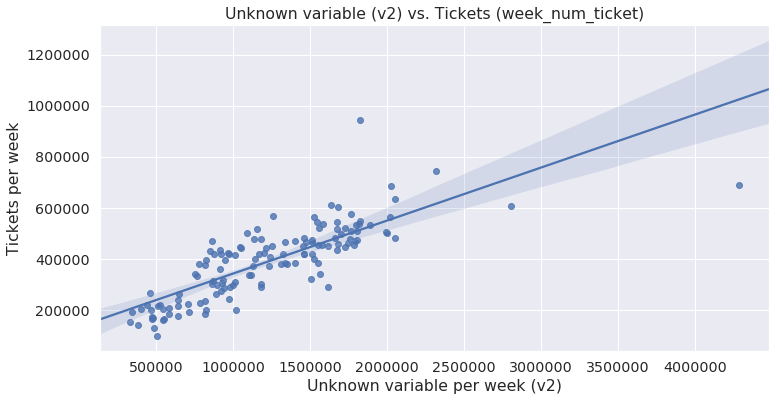

In [16]:
x, y = df_weekly.v2, df_weekly.week_num_ticket

plt.figure(figsize=(12, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(font_scale=1.3)
plt.title('Unknown variable (v2) vs. Tickets (week_num_ticket)')

ax = sns.regplot(x, y)
ax.set(xlabel='Unknown variable per week (v2)', ylabel='Tickets per week')
plt.show()

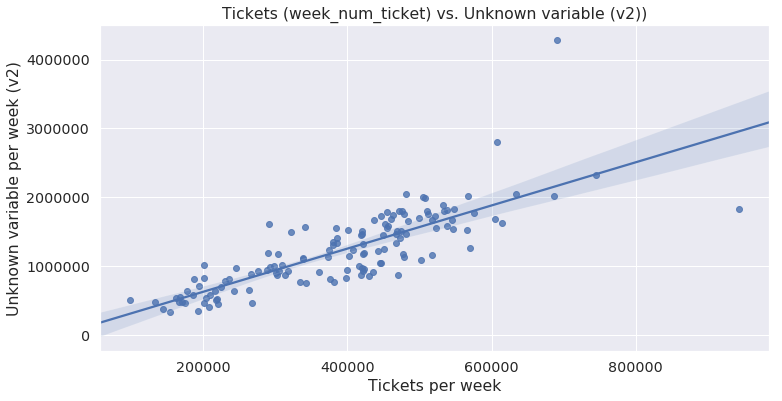

In [17]:
x, y = df_weekly.week_num_ticket, df_weekly.v2

plt.figure(figsize=(12, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(font_scale=1.3)
plt.title('Tickets (week_num_ticket) vs. Unknown variable (v2))')

ax = sns.regplot(x, y)
ax.set(xlabel='Tickets per week', ylabel='Unknown variable per week (v2)')
plt.show()

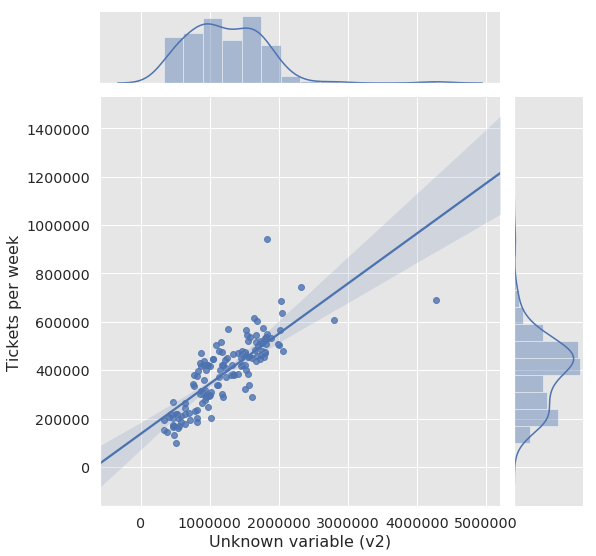

In [18]:
x, y = df_weekly.v2, df_weekly.week_num_ticket

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
h = sns.jointplot(x,y, data=y, height=8, kind="reg")
h.set_axis_labels('Unknown variable (v2)', 'Tickets per week', fontsize=16)
plt.show()

### The next approach to check if the time series is stationary is be looking at its Summary Statistics.

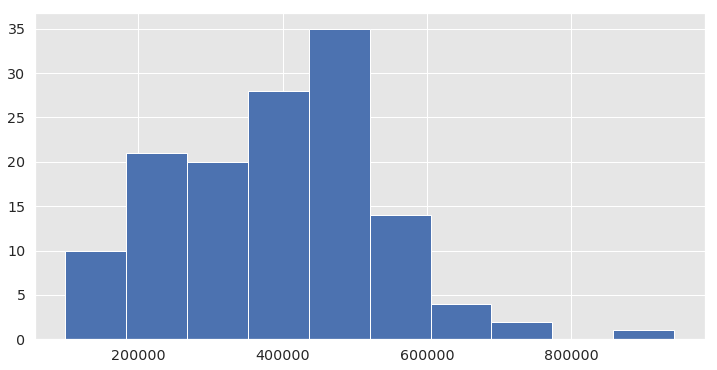

In [19]:
plt.figure(figsize=(12, 6))
df_weekly.week_num_ticket.hist()
plt.show()

### Split the dataset into two and calculate the mean and variance for each group.
### We can confirm here (again) that we have a non-stationary time series because each group's mean and variance look very different.  

In [20]:
X = df_weekly.week_num_ticket
split = len(X) / 2
split = round(split)

X1, X2 = X[0:split], X[split:]

mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=312916.176471, mean2=470385.970149
variance1=19742276779.192268, variance2=8980304872.908186


## ARIMA: Auto-Regressive (AR) Integrated (I) Moving Average (MA) Model

Here at this point, we can try using an ARIMA model because the data is not stationary.  ARIMA model will try to cajole the data to a form where it is stationary.  We do this by taking differences of the variable over time. In ARIMA, there are three methods of “taking differences.” 

### Auto-Regression (AR): A partial difference. The coefficient on the AR term tells the percent of a difference we need to take.
A model that uses the dependent relationship between an observation and some number of lagged observations.

### Integrated (I):  Today’s value minus yesterday’s value.
The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

### Moving Average (MA): Percent to add back into the error term after differencing.
A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


Note:  If the data was stationary, we can use **OLS**.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The **parameters of the ARIMA model **are defined as follows:

>**p**: The number of lag observations included in the model, also called the lag order.

>**d**: The number of times that the raw observations are differenced, also called the degree of differencing.

>**q**: The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.



## ADF Test

### To select the terms that we are going to use for ARIMA, we use an autocorrelation plot and a partial autocorrelation plot to determine the correct number of terms, with an Augmented Dickey-Fuller (ADF) test.

ADF test which is a type of **unit root test**. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.
A time series is stationary if a single shift in time doesn't change the time series statistical properties, in which case unit root does not exist.
 
The Null and Alternate hypothesis of the Augmented Dickey-Fuller test are defined as follows:


>**Null Hypothesis (H0)**:  If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.


>**Alternate Hypothesis (HA)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).


>**p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

>**p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary. 



---



Reference:

[https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

[https://machinelearningmastery.com/time-series-data-stationary-python/](https://machinelearningmastery.com/time-series-data-stationary-python/)

[https://en.wikipedia.org/wiki/Unit_root](https://en.wikipedia.org/wiki/Unit_root)

[https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)
 

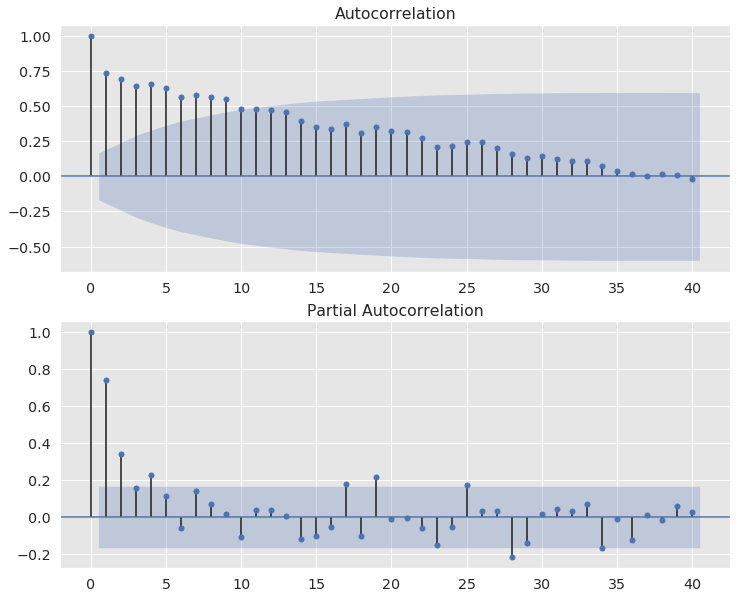

In [21]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(df_weekly.week_num_ticket, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)

fig = sm.graphics.tsa.plot_pacf(df_weekly.week_num_ticket, lags=40, ax=ax2)
plt.show()

### The statsmodels library contains the adfuller function for performing the ADF test.

In [22]:
# print the Augmented Dickey-Fuller Test (ADF) Results
print(statsmodels.tsa.stattools.adfuller(df_weekly.week_num_ticket))

(-1.8314103063642964, 0.36498258279367934, 4, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 3103.7410290256835)


### Create a class called StationarityTests to hold the ADF function. 
Our class constructor accepts a significance level as a parameter. This is defaulted to a significance level of 5%. 
It also contains an **isStationary** variable that will hold the results of the Augmented Dickey-Fuller test. 
If the time series is stationary, isStationary will be ***True***, otherwise it will be ***False***.

Lastly, we add the ADF implementation via a function called **ADF_Stationarity_Test**. 
This function takes a 1d-Array as input and a variable defaulted to True to determine if the function should print the full ADF results. 
The **Akaike Information Criterion (AIC)** is used to determine the lag.

The **adfuller** function returns a tuple of statistics from the ADF test such as the **Test Statistic, P -Value, Number of Lags Used, Number of Observations used for the ADF regression and a dictionary of Critical Values**.


In [0]:
# Credit to: http://www.insightsbot.com/blog/1MH61d/augmented-dickey-fuller-test-in-python
# create a class called StationarityTests to hold the ADF function. 
# Our class constructor accepts a significance level as a parameter. This is defaulted to a significance level of 5%. 
# It also contains an isStationary variable that will hold the results of the Augmented Dickey-Fuller test. 
# If the time series is stationary, isStationary will be True, otherwise it will be False.

class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = statsmodels.tsa.stattools.adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [24]:
sTest = StationarityTests()

sTest.ADF_Stationarity_Test(df_weekly.week_num_ticket, printResults = True)

print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -1.831410
P-Value                   0.364983
# Lags Used               4.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64
Is the time series stationary? False


### The adfuller function returns a tuple of statistics from the ADF test such as the Test Statistic, P -Value, Number of Lags Used, Number of Observations used for the ADF regression and a dictionary of Critical Values.

### If the P-Value is less than the Significance Level defined, we reject the Null Hypothesis (H0) that the time series contains a unit root. 
### In other words, by rejecting the Null hypothesis (H0), we can conclude that the time series is stationary (HA).

### If the P-Value is very close to the significance level, we can use the Critical Values to determine the stationarity.

### We see from the results above that the P-Value is 0.364983 which is greater than the default Significance Level of 0.05.
### Thererfore, we *fail to reject* the null hypothesis that unit root exists. 
### We conclude that the time series *contains a unit root*, and that the series is *not stationary*.

### Another way to interpret this test is using the Critical Value (ADF Test Statistic) which comes up to -1.831410. 
### This is greater than the 5% Critical Value of -2.884042 (or the significance that we need) and therefore we *fail to reject* the null hypothesis. 



---



## Fit an ARIMA(0, 1, 1) model, training on the entire dataset (135 rows).

### This sets the lag value to 0 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 1.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

                             ARIMA Model Results                              
Dep. Variable:      D.week_num_ticket   No. Observations:                  134
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1711.584
Method:                       css-mle   S.D. of innovations          85084.111
Date:                Fri, 04 Oct 2019   AIC                           3429.168
Time:                        08:21:39   BIC                           3437.862
Sample:                             1   HQIC                          3432.701
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2581.9397   2127.752      1.213      0.227   -1588.377    6752.256
ma.L1.D.week_num_ticket    -0.7160      0.067    -10.700      0.000      -0.847      -0.585


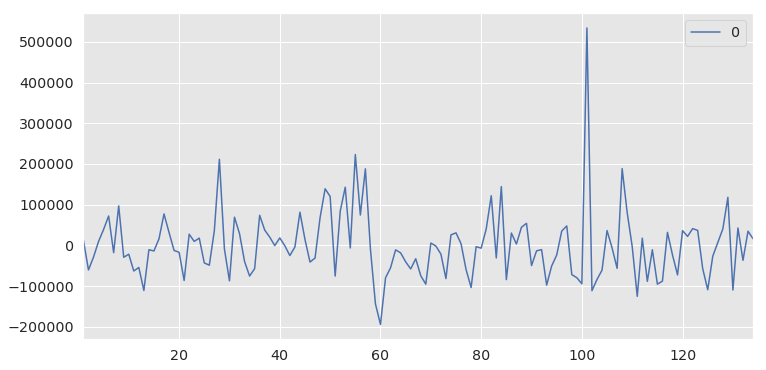

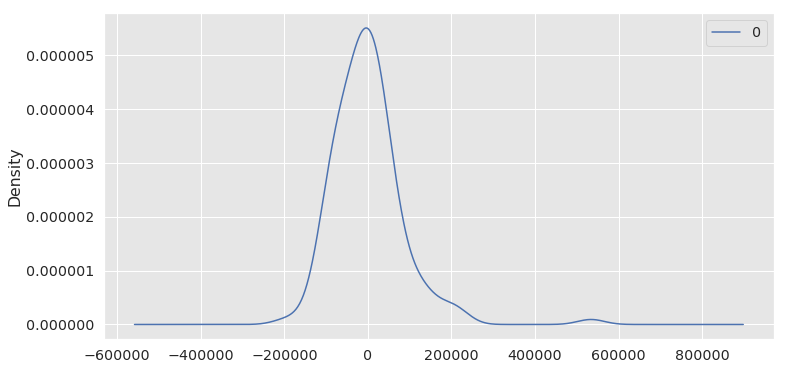

                   0
count     134.000000
mean     -206.857607
std     85436.259338
min   -194408.410292
25%    -56204.909684
50%     -7949.431952
75%     35805.015354
max    534019.090890


In [25]:
from statsmodels.tsa.arima_model import ARIMA

series = df_weekly.week_num_ticket

# fit model
model = ARIMA(series, order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(12,6))
plt.show()

residuals.plot(kind='kde', figsize=(12,6))
plt.show()

# summary statistics
print(residuals.describe())



---



## Train an ARIMA model using 70% of the data and test it on rest of 30% of data to measure its performance.

training set size: 94
test set size: 41
date = 2018-10-22 00:00:00,  predicted=435032.973227,  expected=407400.000000
date = 2018-10-29 00:00:00,  predicted=422808.890479,  expected=422560.000000
date = 2018-11-05 00:00:00,  predicted=425241.335998,  expected=477340.000000
date = 2018-11-12 00:00:00,  predicted=454847.699420,  expected=502360.000000
date = 2018-11-19 00:00:00,  predicted=482190.438251,  expected=398920.000000
date = 2018-11-26 00:00:00,  predicted=442759.138396,  expected=373440.000000
date = 2018-12-03 00:00:00,  predicted=410035.735891,  expected=338440.000000
date = 2018-12-10 00:00:00,  predicted=373911.897723,  expected=942740.000000
date = 2018-12-17 00:00:00,  predicted=604212.459577,  expected=451480.000000
date = 2018-12-24 00:00:00,  predicted=540687.330377,  expected=449980.000000
date = 2018-12-31 00:00:00,  predicted=515124.730810,  expected=451640.000000
date = 2019-01-07 00:00:00,  predicted=498854.336035,  expected=534200.000000
date = 2019-01-14 00:00:

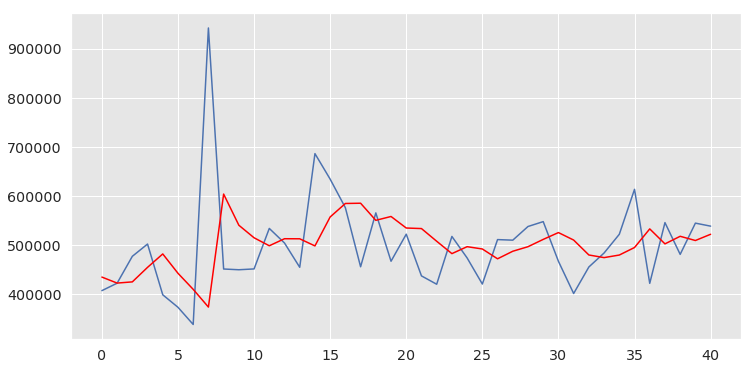

In [26]:
X = df_weekly.week_num_ticket.values  
D = df_weekly.week.values  

#Use 70% of data as training, rest 30% to test model
size = int(len(X) * 0.70)
print("training set size:", size)
print("test set size:", int(len(X) - size))
train, test, train_dates, test_dates = X[0:size], X[size:len(X)], D[0:size], D[size:len(D)]

history = [x for x in train]
predictions = list()

for t in range(len(test)):
  model = ARIMA(history, order=(0,1,1))  # lag value = 0 for autogression, diff order = 1 to make time series stationary, moving average = 1
  model_fit = model.fit(disp=0)   # disp=0 sets debug info off
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  test_date = pd.Timestamp(test_dates[t])
  print('date = %s,  predicted=%f,  expected=%f' % (test_date, yhat, obs))

# save trained model to file
model_fit.save('/content/gdrive/My Drive/Robinhood/arima_011_70-30_model.pkl')

a = np.asarray(predictions)
np.savetxt("/content/gdrive/My Drive/Robinhood/arima_011_70-30_predictions.csv", a, delimiter=",")

# measure model performance using MSE (other metrics can be used)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Using the ARIMA(1,1,1) model trained on entire dataset (135 rows) and make predictions for next 3 months (12 weeks into future).

### Reference: https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/

In [27]:
!pip install pyramid-arima

In [28]:
from pyramid.arima import auto_arima

# use entire dataset for training (135 rows)
data = df_weekly.week_num_ticket.values
print("number of rows in training data:", data.shape[0])

stepwise_model = auto_arima(data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',  
                           suppress_warnings=True, stepwise=True)

# save trained model to file
model_fit.save('/content/gdrive/My Drive/Robinhood/arima_011_train_all_model.pkl')

# print AIC
print(stepwise_model.aic(), "\n")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a pac

number of rows in training data: 135
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3170.469, BIC=3184.489, Fit time=0.472 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3251.788, BIC=3257.396, Fit time=0.028 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3205.892, BIC=3217.108, Fit time=0.289 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3168.962, BIC=3180.178, Fit time=0.307 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3170.839, BIC=3184.859, Fit time=0.447 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3211.805, BIC=3220.217, Fit time=0.067 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3170.812, BIC=3184.832, Fit time=0.936 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3172.712, BIC=3189.536, Fit time=3.535 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3206.515, BIC=3214.927, Fit time=0.165

In [29]:
train = df_weekly.week_num_ticket.values

# train the model using entire dataset (135 rows)
stepwise_model.fit(train)

# predict 12 periods forward (3 months)
future_forecast = stepwise_model.predict(n_periods=12)

# save predictions to file
np.savetxt("/content/gdrive/My Drive/Robinhood/arima_011_predictions.csv", future_forecast, delimiter=",")

# print model statistics
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1580.481
Date:                            Fri, 04 Oct 2019   AIC                           3168.962
Time:                                    08:21:53   BIC                           3180.178
Sample:                                         0   HQIC                          3173.518
                                            - 135                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    337.7362   1616.518      0.209      0.835   -2830.582    3506.054
ma.L1         -0.6602      0.113     -5.828      0.000      -0.882      -0.438
ma.S.L12      -0.8213      0.134     -6.112      0.000      -1.085      -0.558
sigma2      1.552e+10      0.000   3.69e+13      0.000    1.55e+10    1.55e+10
===================================================================================
Ljung-Box (Q):                       53.93   Jarque-Bera (JB):               367.33
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               3.17   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+30. Standard errors may be unstable.
"""

In [30]:
data = pd.Series(df_weekly.week_num_ticket.values)

future_forecast = pd.Series(future_forecast)

future_data = pd.concat([data, future_forecast], axis=0).to_frame()
future_data = future_data.reset_index(drop=True)
future_data.columns = ['week_num_ticket']

# save data including predictions to file
np.savetxt("/content/gdrive/My Drive/Robinhood/arima_011_data+predictions.csv", future_data, delimiter=",")

future_data

,week_num_ticket
0,192860.000000
1,207540.000000
2,143960.000000
3,154580.000000
4,185860.000000
5,220920.000000
6,268100.000000
7,201520.000000
8,313900.000000
9,217960.000000


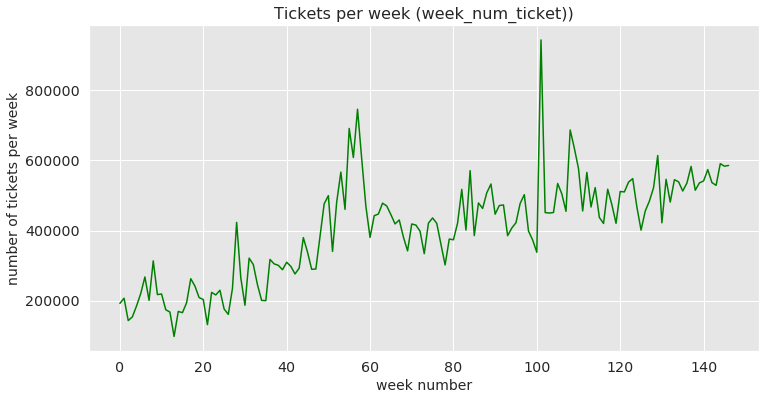

In [31]:
plt.figure(figsize=(12, 6))
plt.title('Tickets per week (week_num_ticket))', fontsize=16)
plt.xlabel('week number', fontsize=14)
plt.ylabel('number of tickets per week', fontsize=14)
plt.plot(future_data, color='green')
plt.show()